In [1]:
import numpy as np
import pandas as pd
from amplpy import AMPL
import math
import matplotlib.pyplot as plt
from IPython.utils import io
%cd /home/jeroen/repos/traffic-scheduling/

/home/jeroen/repos/traffic-scheduling


## Direct transcription for delay objective

In [2]:
def motion_synthesize(T, B=10, dt=0.1, vmax=1, amax=0.5, l=1, prev=None):
    """Solve the MotionSynthesize problem with direct transcription to a linear program.
    A part of the predecessor's trajectory can be specified by `prev`, which is a list
    of positions, starting from the first time epoch of this problem.
    """
    model = r"""
    param T; # number of discrete time epochs
    param dt; # discrete time epoch size
    set Ts = 1..T; # epoch indices

    param vmax; # maximum velocity
    param umax; # maximum control
    param p0; # start position, must be < 0
    param l; # minimum follow distance

    # state and control variables
    var x {Ts}; # position
    var v {Ts}; # velocity
    var u {Ts}; # control (acceleration)

    maximize objective: sum {t in Ts} x[t];

    subject to x_start: x[1] = p0;
    subject to v_start: v[1] = vmax;
    subject to x_end: x[T] = 0;
    subject to v_end: v[T] = vmax;

    subject to v_bounds {t in Ts}: 0 <= v[t] <= vmax;
    subject to u_bounds {t in Ts}: -umax <= u[t] <= umax;

    # forward Euler
    subject to integrate_x {t in 1..T-1}: x[t+1] = x[t] + dt*v[t];
    subject to integrate_v {t in 1..T-1}: v[t+1] = v[t] + dt*u[t];
    """

    # add follow constraint for vehicle ahead
    if prev is not None:
        model += r"""
        param Y; # number of discrete time steps for trajectory ahead
        set Ys = 1..Y;
        param y {Ys}; # position of vehicle in front
        subject to follow {t in Ys}: y[t] - x[t] >= l;"""

    ampl = AMPL()
    ampl.eval(model)

    ampl.param["dt"] = dt
    ampl.param["T"] = T
    ampl.param["p0"] = -B
    ampl.param["vmax"] = vmax
    ampl.param["umax"] = amax
    ampl.param["l"] = l

    if prev is not None:
        ampl.param["Y"] = len(prev)
        ampl.param["y"] = prev

    # suppress solver output
    with io.capture_output() as captured:
        ampl.solve(solver="gurobi");
    assert ampl.solve_result == "solved"
    return ampl.get_variable("x").to_pandas().T.values.tolist()[0]

## Example

In [60]:
# location of the intersection
B, E = 30, 40
dt = 0.1
params = { 'dt': dt, 'vmax': 1, 'amax': 0.1, 'l': 5, 'B': B }
instance = { 'release': [[10, 15, 24], [20, 25, 40]] }
y = [[40.001, 45.001, 70], [55, 60, 80]]

In [61]:
def plot_trajectories(instance, y, params):
    fig, ax = plt.subplots()
    ax.set_xlabel('t')
    ax.set_ylabel('x(t)')
    # plot the intersection region
    plt.axhspan(B, E, alpha=0.2)

    # split axis and invert ticks
    step = 10
    ticks = np.arange(0, B, step)
    double_ticks = np.concat([ticks, E + step + np.flip(ticks)])
    labels = np.concat([ticks, ticks])
    plt.yticks(ticks=double_ticks, labels=labels)
    ax = plt.gca()

    # full speed part over intersection (same everytime)
    xfull = pd.DataFrame(np.arange(0, math.ceil(E - B), dt), columns=['x'])
    xfull['t'] = np.arange(0, math.ceil((E - B) / params['vmax']), dt)

    for i in range(len(y)):
        prev = None
        for release, cross in zip(instance['release'][i], y[i]):
            # discretize times
            release = math.ceil(release / dt)
            cross = math.ceil(cross / dt)
            if prev is not None:
                # extract the relevant steps from prev trajectory
                prev = prev[prev['t'] > release * dt]['x'].to_numpy()
                
            x = motion_synthesize(cross - release, prev=prev, **params)
            xd = pd.DataFrame(x, columns=['x'])
            xd['t'] = np.arange(release * dt, cross * dt, dt)
            prev = xd.copy() # copy before shifting

            # add full speed part
            xend = xfull.copy()
            xend['t'] += cross * dt
            xd = pd.concat([xd, xend])
            
            if i == 0:
                xd['x'] += B
                xd[xd['x'] < E].plot(x='t', y='x', color='r', ax=ax, legend=False)
            else:
                xd = xd[xd['x'] < E]
                xd['x'] = E - xd['x']
                xd.plot(x='t', y='x', color='g', ax=ax, legend=False)

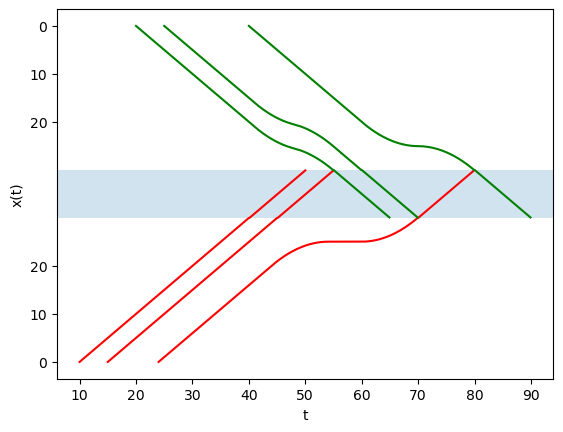

In [62]:
plot_trajectories(instance, y, params)
plt.savefig('motion/trajectories_delay.pdf')
plt.show()